# fMRI Data Loading and Normalization in Python 
**V.0.2 - Beta, [Contributions](#contributions)**   

### Goal of this script
 1. load the fMRI data into python
     - 3 recall runs
 2. create an average brain mask from multiple runs
     - ses01_brain (3 recall runs)
 3. trim TRs from the beginning AND end of each run (and apply this trimming to the confounds as well)
     - save volume as _trimTRs.nii.gz
 4. apply a high-pass filter and z-score the data
     - save volume as _trim_norm.nii.gz
 5. concatenate runs to make one time series
     - recall, in a standardized order

### Note: these data are not being analyzed in the published manuscript

In [10]:
ipynby=0 #python notebook or not july 2
if ipynby==0:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-subject', type=str)
    args = parser.parse_args()
    print(args.subject)
    subject=args.subject
if ipynby==1:
    subject=2

In [11]:
sub ='sub-0'+str(subject)
subS = str(int(subject))
ses = 'ses-01'
task='recall'
n_trunc=3 # Number of volumes to trim/truncate
print(sub)
#one thing about n_trunc=if set to 100, moves mstr back 2 and resets to zero. 
#here you can see a nice hrf peaking around the time of movie onset bc score screen was ~ 4 s before

sub-02


In [12]:
#import packages
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import time
import os
import shutil
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn.datasets import load_mni152_template
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
from nilearn.image.image import mean_img
from nilearn.image import resample_to_img
from scipy import stats
from sklearn import preprocessing
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt 
import scipy.io
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
if ipynby==1:
    %matplotlib inline 
    %autosave 30

Autosaving every 30 seconds


In [13]:
# load some helper functions and import data / settings
import ss_utils
from ss_utils import load_ss_epi_data, load_ss_mask, mask_data, load_data
from ss_utils import ss_dir, ss_bids_dir, ss_TR, ss_hrf_lag, run_names, n_runs
print('TASK:', task)
 
firstrun=1
lastrun=3
n_runs_recall = lastrun-firstrun+1

bold_dir=ss_bids_dir + 'derivatives/fmriprep/%s/%s/func/' % (sub, ses)
anat_dir=ss_bids_dir + '%s/%s/anat/' % (sub, ses)
anat_fmriprep_dir=ss_bids_dir + 'derivatives/fmriprep/%s//anat/' % sub
out_dir= ss_bids_dir + 'derivatives/firstlevel/%s/' % sub
mask_fold = ss_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
ses1_dir=ss_bids_dir + 'derivatives/fmriprep/%s/ses-01/func/' % sub

#load g_o
ss_tngs=9
analysis_dir=ss_dir+'analysis/'
nonfmri_dir=ss_dir+'data/nonfmri/%s/' %subS
mat_fname=nonfmri_dir+'g_o.mat'
mat_contents = scipy.io.loadmat(mat_fname)
g_o = mat_contents['g_o']
mat_fname=nonfmri_dir+'MSMEhr.mat'
mat_contents = scipy.io.loadmat(mat_fname)
RSTR = mat_contents['RSTR'] #movie start TRs
RETR = mat_contents['RETR'] #movie end TRs
hrshiftval=5
fwhmval=5

print('bids dir = %s' % (ss_bids_dir))
print('anat dir = %s' % (anat_dir))
print('subject dir = %s' % (bold_dir))
print('output dir = %s' % (out_dir))
print('number of recall runs = %d' % (n_runs_recall))
print('number of games = %d' % (ss_tngs))
print('TR = %s seconds' % (ss_TR))
print('trim %d volumes from each run' % (n_trunc))

print('Game order = %s' % (g_o))
print('Recall start times = %s' % (RSTR))
print('Recall end times = %s' % (RETR))

TASK: recall
bids dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/
anat dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/sub-02/ses-01/anat/
subject dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/fmriprep/sub-02/ses-01/func/
output dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/
number of recall runs = 3
number of games = 9
TR = 1 seconds
trim 3 volumes from each run
Game order = [[3 5 9 8 1 6 4 2 7]]
Recall start times = [[1.00000000e+00 1.63309649e-03]
 [1.25000000e+02 3.72476876e-04]
 [2.18000000e+02 9.99081738e-01]
 [1.00000000e+00 2.78163049e-03]
 [1.19000000e+02 1.07884696e-02]
 [2.35000000e+02 1.41751673e-02]
 [1.00000000e+00 9.37609375e-03]
 [7.80000000e+01 8.38574674e-03]
 [1.48000000e+02 8.08440614e-03]]
Recall end times = [[1.24000000e+02 6.26482597e-01]
 [2.18000000e+02 7.06903573e-01]
 [2.84000000e+02 9.87654962e-02]
 [1.1800000

In [14]:
#Select confounds and trim volumes from confounds file
#Choose the desired confounds from the confounds_regressors.tsv file from fmriprep, trim the columns corresponding to trimmed volumes, and save as a .txt file. 
starttime = time.time()
confounds=[]
confounds_all=[]
mc_all=[]
ntr=[]
ntr=np.zeros((n_runs_recall,1))

for r in range(firstrun,lastrun+1):
    fname='_ses-01_task-recall_run-0%i_desc-confounds_regressors.tsv' % (r)
    confounds = pd.read_csv(ses1_dir + sub + fname,  sep='\t', header=(0))
    confounds_selected=confounds[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','framewise_displacement','a_comp_cor_00','a_comp_cor_01','a_comp_cor_02','a_comp_cor_03','a_comp_cor_04','a_comp_cor_05']][n_trunc:]
    confounds_selected=pd.DataFrame(confounds_selected)
    confounds_selected.to_csv(out_dir + 'ses-01/' + sub + '_ses-01_task-recall_run-0%i_confounds_selected.txt' % r, index=False, sep='\t', mode='w')
    if 0==firstrun:
        ntr[r]=confounds_selected.shape[0]
    if 1==firstrun:
        ntr[r-1]=confounds_selected.shape[0]
    if r==firstrun:
        confounds_all=confounds_selected
    else:
        confounds_all=np.vstack([confounds_all,confounds_selected])
print(confounds_selected.shape[0])
print(ntr)
print(sum(ntr[0]))

208
[[289.]
 [345.]
 [208.]]
289.0


[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]


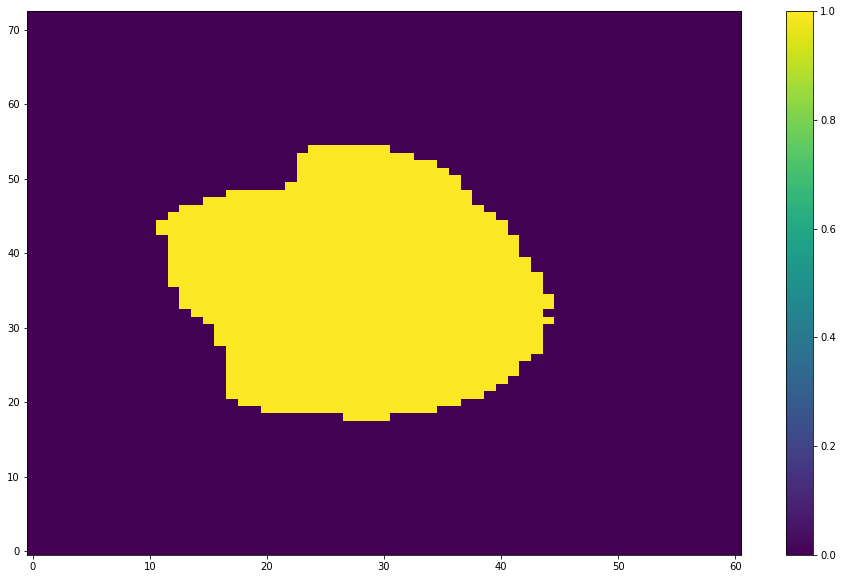

In [15]:
mask_imgs=[]
for run in range(firstrun,lastrun+1):
    mask_name = ses1_dir + sub + '_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz' % run
    mask_imgs.append(mask_name)

template = load_mni152_template()
i=np.eye(3)*3
template =image.resample_img(template, target_affine=i) 
# intersect 3 view brain masks    
avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)
avg_mask = resample_to_img(avg_mask, template)
thresha=avg_mask.dataobj>-10000
thresh=avg_mask.dataobj>0.5
avg_mask.dataobj[thresha] = 0
avg_mask.dataobj[thresh] = 1
if ipynby==1:
    crange=1
    plt.figure(figsize=(16,10))
    this_img = avg_mask.dataobj[50,:,:]; 
    plt.imshow(this_img,cmap="viridis",vmin=0,vmax=crange,origin='lower',interpolation='none',aspect="auto")
    cbar = plt.colorbar()
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
print(affine_mat)
coords = np.where(avg_mask.get_fdata())

/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/fmriprep/sub-02//anat/sub-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


"hdr = avg_mask.header  # get a handle for the .nii file's header\nhdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))\nnib.save(avg_mask, output_name_mask)"

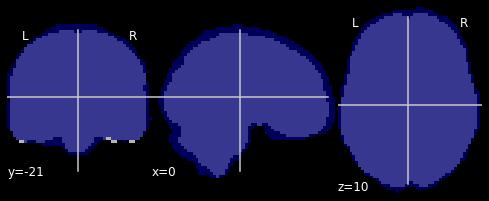

In [16]:
#plot average brain????
t1_file = anat_fmriprep_dir + sub + '_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
print(t1_file)
t1_img = image.load_img(t1_file)
t1_img = resample_to_img(t1_img, template)
if ipynby==1:
    plot_roi(avg_mask, bg_img=t1_img)

# Save the mask
output_name_mask = mask_fold + '%s_%s_brain.nii.gz' % (sub, ses)
'''hdr = avg_mask.header  # get a handle for the .nii file's header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(avg_mask, output_name_mask)'''

In [17]:
def mod_smooth(in_file, mask_file, fwhm, smooth_type):
    import nipype.interfaces.fsl as fsl
    import nipype.interfaces.freesurfer as fs
    import os
    if smooth_type == 'susan':
        if fwhm == 0:
            return in_file
        smooth = create_susan_smooth()
        smooth.base_dir = out_dir#os.getcwd()
        smooth.inputs.inputnode.fwhm = fwhm
        smooth.inputs.inputnode.mask_file = mask_file
        smooth.inputs.inputnode.in_files = in_file
        #smooth.outputs.outputnode.smoothed_files='/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/ses-01/sub-02_ses-01_task-recall_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3TRs_smooth.nii.gz'
        res = smooth.run()
        smoothed_file=[] #smoothed_file = res.outputs.outputnode.smoothed_files
    return smoothed_file

In [18]:
#truncate first n_trunc TRs
#confounds_trunc=confounds_selected[3:end]
epi_trunc=[]
#https://github.com/INCF/BrainImagingPipelines/blob/master/bips/workflows/gablab/wips/scripts/modular_nodes.py
print('Number of runs to concatenate:', n_runs_recall)

for run in range(firstrun,lastrun+1):#lastrun+1
    out_smooth=(out_dir + 'ses-01/' + '%s_ses-01_task-recall9_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_smooth%d.nii.gz' % (sub, run, n_trunc,fwhmval))
    if os.path.exists(out_smooth):
        proceeeeed=[]

        epi_data=nib.load(out_smooth)
        epi_data=resample_to_img(epi_data, template)# JWA, August 25 change
        epi=epi_data.get_fdata()

        #truncate
        epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc))
        epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc:]

        print(epi_data.shape, '  ', epi_trunc.shape)
        dimsize=epi_data.header.get_zooms()
        #print(dimsize)
        orig_dimsize=dimsize

        affine_mat = epi_data.affine  # What is the orientation of the data
        print(affine_mat)
    else:
        epi_file=ses1_dir + sub + '_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % run
        epi_data=nib.load(epi_file)
        epi_data=resample_to_img(epi_data, template)# JWA, August 25 change
        epi=epi_data.get_fdata()

        #truncate
        epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc))
        epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc:]

        print(epi_data.shape, '  ', epi_trunc.shape)
        dimsize=epi_data.header.get_zooms()
        #print(dimsize)
        orig_dimsize=dimsize

        affine_mat = epi_data.affine  # What is the orientation of the data
        print(affine_mat)

        # Save the volume
        output_name = (out_dir + 'ses-01/' + '%s_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%dTRs.nii.gz' % (sub, run, n_trunc))

        bold_nii = nib.Nifti1Image(epi_trunc, affine_mat)
        hdr = bold_nii.header  # get a handle for the .nii file's header
        hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2], dimsize[3]))
        nib.save(bold_nii, output_name)

        # smooth with susan 
        smoothed_file = mod_smooth(output_name,output_name_mask,fwhmval, 'susan')

        #move file
        in_smooth=(out_dir+'susan_smooth/smooth/mapflow/_smooth0/' + '%s_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%dTRs_smooth.nii.gz' % (sub, run, n_trunc))
        #out_smooth=(out_dir + 'ses-01/' + '%s_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_smooth%d.nii.gz' % (sub, run, n_trunc,fwhmval))
        os.rename(in_smooth,out_smooth)

Number of runs to concatenate: 3
(61, 73, 61, 292)    (61, 73, 61, 289)
[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
190830-14:35:03,691 nipype.workflow INFO:
	 Workflow susan_smooth settings: ['check', 'execution', 'logging', 'monitoring']
190830-14:35:03,732 nipype.workflow INFO:
	 Running serially.
190830-14:35:03,734 nipype.workflow INFO:
	 [Node] Setting-up "susan_smooth.mask" in "/mnt/bucket/labs/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/susan_smooth/mask".
190830-14:35:03,740 nipype.workflow INFO:
	 [Node] Outdated cache found for "susan_smooth.mask".
190830-14:35:03,767 nipype.workflow INFO:
	 [Node] Setting-up "_mask0" in "/mnt/bucket/labs/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/susan_smooth/mask/mapflow/_mask0".
190830-14:35:03,771 nipype.workflow INFO:
	 [Node] Outdated cache found for "_mask0".
190830-14:35:03,819 ni

190830-14:40:05,955 nipype.workflow INFO:
	 [Node] Outdated cache found for "_mask0".
190830-14:40:06,26 nipype.workflow INFO:
	 [Node] Running "_mask0" ("nipype.interfaces.fsl.utils.ImageMaths"), a CommandLine Interface with command:
fslmaths /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/ses-01/sub-02_ses-01_task-recall_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3TRs.nii.gz -mas /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/masks/sub-02_ses-01_brain.nii.gz /mnt/bucket/labs/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/susan_smooth/mask/mapflow/_mask0/sub-02_ses-01_task-recall_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3TRs_mask.nii.gz
190830-14:40:38,992 nipype.workflow INFO:
	 [Node] Finished "_mask0".
190830-14:40:39,2 nipype.workflow INFO:
	 [Node] Finished "susan_smooth.mask".
190830-14:40:39,3 nipype.workflow IN

190830-14:45:25,426 nipype.workflow INFO:
	 [Node] Finished "_mask0".
190830-14:45:25,436 nipype.workflow INFO:
	 [Node] Finished "susan_smooth.mask".
190830-14:45:25,437 nipype.workflow INFO:
	 [Node] Setting-up "susan_smooth.meanfunc2" in "/mnt/bucket/labs/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/susan_smooth/meanfunc2".
190830-14:45:25,441 nipype.workflow INFO:
	 [Node] Outdated cache found for "susan_smooth.meanfunc2".
190830-14:45:25,459 nipype.workflow INFO:
	 [Node] Setting-up "_meanfunc20" in "/mnt/bucket/labs/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/susan_smooth/meanfunc2/mapflow/_meanfunc20".
190830-14:45:25,462 nipype.workflow INFO:
	 [Node] Outdated cache found for "_meanfunc20".
190830-14:45:25,501 nipype.workflow INFO:
	 [Node] Running "_meanfunc20" ("nipype.interfaces.fsl.utils.ImageMaths"), a CommandLine Interface with command:
fslmaths /mnt/bucket/labs/norman/jantony/surpris

## Load fMRI data <a id="load_fmri"></a>

#### Get voxels from an ROI

We will extract BOLD data, only for voxels in a mask, by executing the following sequence of steps: 
1. load whole brain fMRI data (for a given subject and a given run)
2. load the desired mask
3. use `NiftiMasker` to sub-select mask voxels from the whole brain data
    - `NiftiMasker` is a function from nilearn. Here's <a href="https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html">an example</a> about how to use it, and here's the official <a href="https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html">documentation</a>. 

## Apply mask to truncated dataset

In [19]:
epi_mask_data_all=[]

for run in range(firstrun,lastrun+1):# Load the fMRI data 
    print('now on run:', run)
    epi_masker= NiftiMasker(mask_img=avg_mask,  high_pass=1/128,
        standardize=True,  # Are you going to zscore the data across time? 
        t_r=ss_TR, 
        memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
        memory_level=1,  # How much memory will you cache?
        verbose=0)

    epi_file=out_dir + 'ses-01/' + '%s_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_smooth%d.nii.gz' % (sub, run, n_trunc,fwhmval)
    #confound_file= bold_dir + '%s_confounds_selected_r0%i.txt' % (sub, run) #uncommented from Lizzie
    confound_file= bold_dir + 'sub-%s_ses-01_task-recall_run-%s_desc-confounds_regressors.tsv' %(sub,run)
    if run==firstrun:
        if 0==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[0:int(sum(ntr[run])),:]) #commented from Lizzie
        if 1==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[0:int(sum(ntr[run-1])),:]) #commented from Lizzie
        epi_mask_data_all=epi_mask_data
        nTR_all=epi_mask_data.shape[0]
    else:
        if 0==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[int(sum(ntr[0:run])):int(sum(ntr[0:run+1])),:])
        if 1==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[int(sum(ntr[0:run-1])):int(sum(ntr[0:run])),:])
        epi_mask_data_all=np.vstack([epi_mask_data_all,epi_mask_data])
        nTR_all=np.vstack([nTR_all,epi_mask_data.shape[0]])
        
    print('Saving trimmed and normalized volume for run',run)
    affine_mat = avg_mask.affine #should be the same as the epi data
    avg_mask.shape
    coords = np.where(avg_mask.get_fdata())
    bold_vol=[]
    bold_vol=np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_data.shape[0]))
    bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_data.T
    print('epi_mask_data shape:', bold_vol.shape)
    output_name = (out_dir + 'ses-01/' + '%s_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_norm.nii.gz' % (sub, run, n_trunc))
    bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
    hdr = bold_nii.header  # get a handle for the .nii file's header
    hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
    nib.save(bold_nii, output_name)
        
print(epi_mask_data_all.shape)

now on run: 1
Saving trimmed and normalized volume for run 1
epi_mask_data shape: (61, 73, 61, 289)
now on run: 2
Saving trimmed and normalized volume for run 2
epi_mask_data shape: (61, 73, 61, 345)
now on run: 3
Saving trimmed and normalized volume for run 3
epi_mask_data shape: (61, 73, 61, 208)
(842, 78996)


In [20]:
# concatenate volumes
segs = {}
runs = {}
for game in range(ss_tngs):
    #identify game in the order it was shown
    g_num=g_o[0,game]
    seg=np.arange(RSTR[game,0]-1,RETR[game,0]-2,1) #Note the difference of -2 
    seg=seg+hrshiftval #shift for hrf
    #determine which run it was in
    run=np.ceil((game+1)/3)
    if firstrun==1: #most subjects
        if run==2:
            seg=seg+nTR_all[0]
        if run==3:
            seg=seg+nTR_all[0]+nTR_all[1]
    print(seg)
    print(len(seg))
    #if seg: #most subjects
    segs[g_num]=seg
    runs[g_num]=run

[  5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.]
122
[129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 

In [21]:
# re-order concatenated volumes
for g_num in range(1,1+ss_tngs):
    runv=np.repeat(runs[g_num],len(segs[g_num]))
    if g_num==1:
        epi_mask_event=epi_mask_data_all[segs[g_num].astype(int),:]
        confounds_event=confounds_all[segs[g_num].astype(int),:]
        run_event=runv
        print(epi_mask_event.shape)
        print(confounds_event.shape)
        print(run_event.shape)
    else:
        epi_mask_event=np.concatenate([epi_mask_event,epi_mask_data_all[segs[g_num].astype(int),:]],axis=0)
        confounds_event=np.concatenate([confounds_event,confounds_all[segs[g_num].astype(int),:]],axis=0)
        run_event=np.concatenate([run_event,runv],axis=0)
        print(epi_mask_event.shape)
        print(confounds_event.shape)
        print(run_event.shape)

(114, 78996)
(114, 13)
(114,)
(181, 78996)
(181, 13)
(181,)
(303, 78996)
(303, 13)
(303,)
(378, 78996)
(378, 13)
(378,)
(470, 78996)
(470, 13)
(470,)
(577, 78996)
(577, 13)
(577,)
(633, 78996)
(633, 13)
(633,)
(749, 78996)
(749, 13)
(749,)
(814, 78996)
(814, 13)
(814,)


In [22]:
print(run_event)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.

In [23]:
#estimate autocorrelation
'''
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

voxel_id=17891
a1=estimated_autocorrelation(epi_mask_hrf[:, voxel_id])
print(a1.shape)
pts=20
if ipynby==1:
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(a1[0:pts])'''

'\ndef estimated_autocorrelation(x):\n    """\n    http://stackoverflow.com/q/14297012/190597\n    http://en.wikipedia.org/wiki/Autocorrelation#Estimation\n    """\n    n = len(x)\n    variance = x.var()\n    x = x-x.mean()\n    r = np.correlate(x, x, mode = \'full\')[-n:]\n    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))\n    result = r/(variance*(np.arange(n, 0, -1)))\n    return result\n\nvoxel_id=17891\na1=estimated_autocorrelation(epi_mask_hrf[:, voxel_id])\nprint(a1.shape)\npts=20\nif ipynby==1:\n    f, ax = plt.subplots(1,1, figsize=(14,5))\n    ax.plot(a1[0:pts])'

In [24]:
#z-score
epi_mask_event2=epi_mask_event
print(epi_mask_event2.shape)

(814, 78996)


In [25]:
#save confounds_hrf2 as .mat
mat_fname=nonfmri_dir+'confounds_recall.mat'
scipy.io.savemat(mat_fname,{'nTR_all': nTR_all,'confounds_event': confounds_event,'run_event': run_event})

In [26]:
bold_vol_event=[]
bold_vol_event=np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_event2.shape[0]))
bold_vol_event[coords[0], coords[1], coords[2], :] = epi_mask_event2.T
print(bold_vol_event.shape)
print(avg_mask.shape)

(61, 73, 61, 814)
(61, 73, 61)


In [27]:
# Save the concatenated volumes, event file
output_name = out_dir + '%s_task-recall_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_norm_event.nii.gz' % (sub, n_trunc)
print(output_name)
bold_nii = nib.Nifti1Image(bold_vol_event, affine_mat)
hdr = bold_nii.header  # get a handle for the .nii file's header
print(orig_dimsize)
hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
nib.save(bold_nii, output_name)
print('Volume saved')
endtime = time.time()
print(endtime - starttime)


/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/sub-02_task-recall_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3_norm_event.nii.gz
(3.0, 3.0, 3.0, 1.0)
Volume saved
1085.3530838489532


## Plot voxels across runs in game order

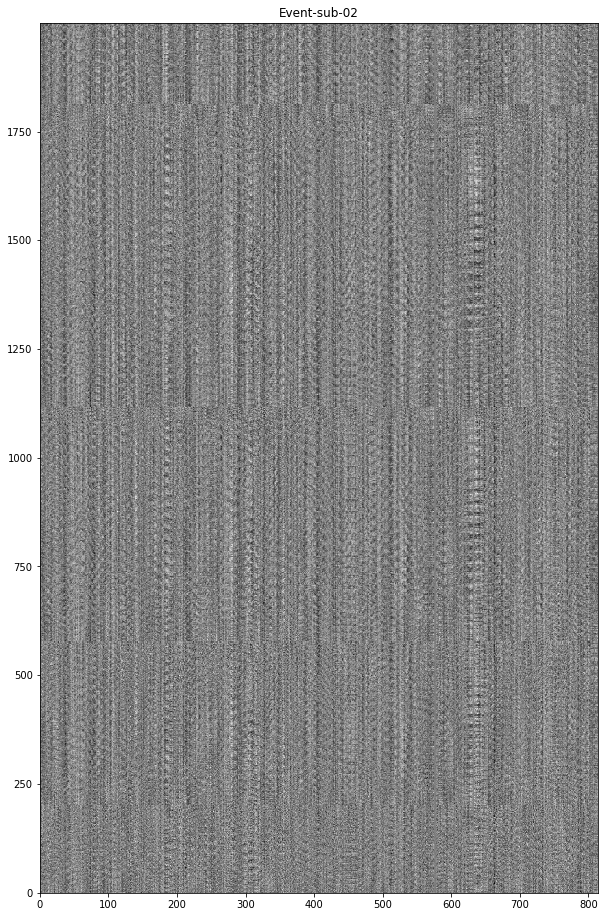

In [28]:
if ipynby==1:
    n_vox=2000
    plt.figure(figsize=(10,16))
    this_img = epi_mask_event2[:,:n_vox]; 
    this_img=this_img.T;#must transform because of how Python reshapes
    tn='Event-%s' %sub;
    plt.imshow(this_img,cmap='gray',origin='lower',interpolation='none',aspect="auto")
    plt.title(tn)

Plotting middle volumed for run 1
Plotting middle volumed for run 2
Plotting middle volumed for run 3


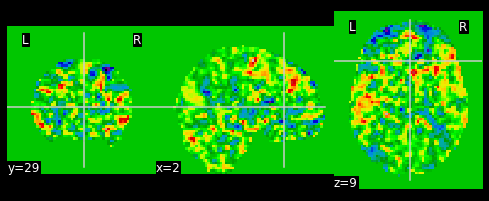

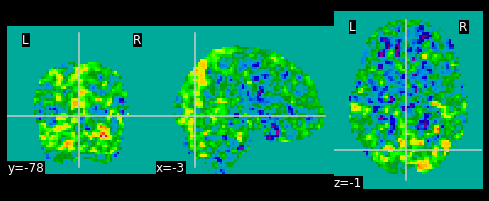

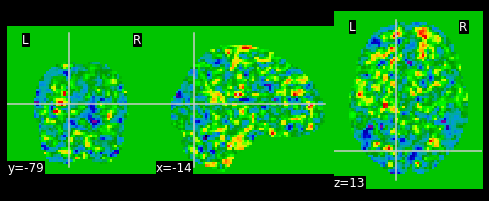

In [29]:
if ipynby==1:
    for run in range(1,n_runs_recall+1):
        func_name=out_dir + 'ses-01/' + '%s_ses-01_task-recall_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_norm.nii.gz' % (sub, run, n_trunc)

        #print(image.load_img(func_name).shape)
        vol_num=round(image.load_img(func_name).shape[3]/2)
        middle_vol = image.index_img(func_name,vol_num)
        #mean_func = mean_img(func_name)
        print('Plotting middle volumed for run',run)
        plot_epi(middle_vol)

### 3.1. Plot a voxel time-series <a id="plot_voxel"></a>

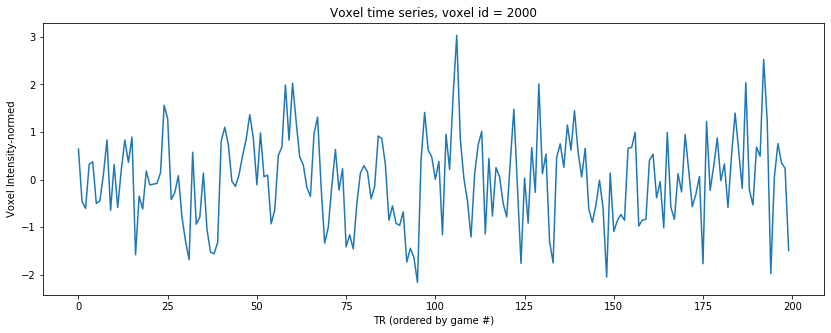

In [30]:
# Plot value of voxel_id through time 
if ipynby==1:
    voxel_id = 2000
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(epi_mask_event2[0:200, voxel_id])
    ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
    ax.set_xlabel('TR (ordered by game #)')
    ax.set_ylabel('Voxel Intensity-normed')

## Check mean and standard deviation of normalized data 

the mean of 1st few time points:
 [ 0.00409407  0.01101599 -0.00067349 -0.00342592  0.00383333 -0.00149799
 -0.00777875 -0.0075445  -0.01160353  0.01507938  0.00309103  0.00559463
  0.01282493  0.00786283  0.00182642 -0.00543904 -0.0109952  -0.01036721
 -0.00397742 -0.00397158 -0.01007523  0.00075421  0.01822355  0.01259129
  0.02166465  0.02325033  0.01598552  0.00762019  0.00293865  0.00029577
 -0.00319364  0.00785228  0.00208135 -0.0141244   0.00947484 -0.00416148
 -0.01199974 -0.01683735  0.00102733  0.01999226  0.01741218  0.02298627
  0.02364862  0.01358797  0.00255442  0.01373421  0.01104796 -0.0010219
  0.00489651 -0.00833599]

the std of 1st few time points:
 [1.00489253 1.00359433 1.0024661  0.99969315 0.99067796 0.9907258
 0.99876787 1.00577554 0.99703647 0.99812644 1.00445522 0.99770408
 0.9876265  0.98919773 0.99708351 1.0053064  1.00544306 1.0049921
 0.99953501 1.00197072 0.99820488 1.00668782 0.99107123 0.99656413
 0.99217179 0.98995189 0.9927466  1.00132194 1.00043776 1

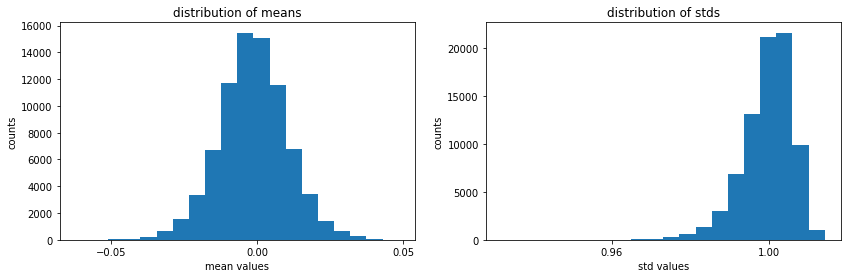

In [31]:
if ipynby==1:
    x_mean = np.mean(epi_mask_event2, axis=0)
    x_std = np.std(epi_mask_event2, axis=0, dtype=np.float64)
    print('the mean of 1st few time points:\n', x_mean[0:50])
    print('')
    print('the std of 1st few time points:\n', x_std[0:50])
    print('')
    print(np.shape(x_mean))
    print(np.shape(x_std))
    print('')
    print(np.amin(x_mean), np.amax(x_mean))
    print(np.amin(x_std), np.amax(x_std))
    # print(x_std)

    f, axes = plt.subplots(1, 2, figsize = (14,4))
    n_bins = 20
    axes[0].hist(x_mean, bins = n_bins)
    axes[0].set_title('distribution of means')
    axes[0].set_xlabel('mean values')
    axes[0].set_ylabel('counts')
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[1].hist(x_std, bins = n_bins)
    axes[1].set_title('distribution of stds')
    axes[1].set_xlabel('std values')
    axes[1].set_ylabel('counts')
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[1].get_xaxis().get_major_formatter().set_useOffset(False)
    plt.show()